In [1]:
import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchmetrics import Accuracy

import torch.optim as optim
from cleverhans.torch.attacks.projected_gradient_descent import (projected_gradient_descent)

import quantus
import captum
from captum.attr import Saliency, IntegratedGradients, NoiseTunnel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import copy
import gc
import math

import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
cifar_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,])

# cifar_transforms = transforms.Compose([transforms.ToTensor()])

In [4]:
test_dataset =  torchvision.datasets.CIFAR10(root= './datasets', train = False, download=True, transform = cifar_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, pin_memory=True)

Files already downloaded and verified


In [5]:
class_names = test_dataset.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
class VGG(nn.Module):
    def __init__(self, features):
        super(VGG,self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Linear(512,10)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def make_layers(cfg):
    layers = []
    in_channels =3
    for out_channels in cfg:
        if out_channels == 'M':
            layers += [nn.MaxPool2d(kernel_size = 2, stride =2)]
        else:
            conv2d = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding =1)
            layers += [conv2d, nn.ReLU(inplace = True)]
            in_channels = out_channels
    return nn.Sequential(*layers)

cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

def vgg16():
    return VGG(make_layers(cfg))

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Normal Training VGG

In [16]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "vgg_cifar.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
model = vgg16().to(device)
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [17]:
def evaluate_model(model, data, device):
    model.eval()
    logits = torch.Tensor().to(device)
    targets = torch.LongTensor().to(device)

    with torch.no_grad():
        for x_batch, y_batch in data:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = torch.cat([logits, model(x_batch)])
            targets = torch.cat([targets, y_batch])
    
    return torch.nn.functional.softmax(logits, dim=1), targets

In [20]:
# Model to GPU and eval mode.
model.to(device)
model.eval()

# Check test set performance.
predictions, labels = evaluate_model(model, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG Normal is: {(100 * test_acc):.2f}%")

Test accuracy for VGG Normal is: 87.01%


In [21]:
gc.collect()
torch.cuda.empty_cache()

x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

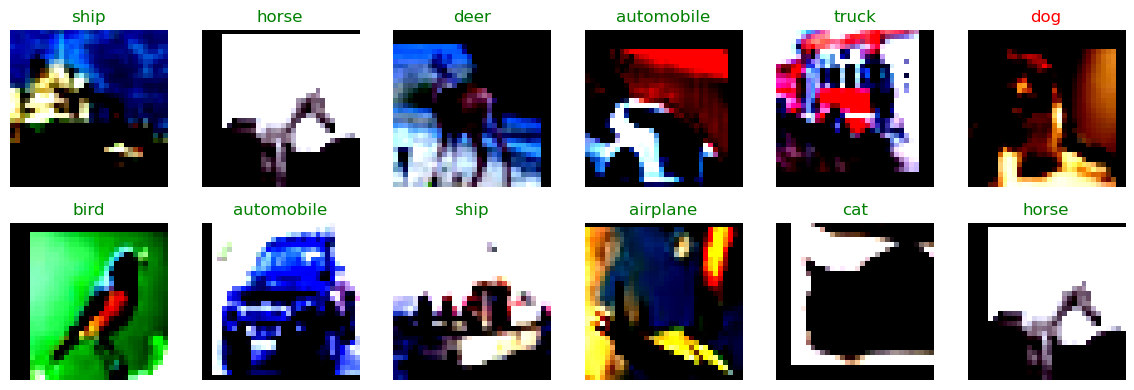

In [28]:
# See random images with their labels
# torch.manual_seed(42)  # setting random seed
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(12, 4))
indexes=[]
rows, cols = 2, 6
for i in range(1, (rows * cols) + 1):
    random_idx = torch.randint(0, len(x_batch), size=[1]).item()
    img, label_gt = x_batch[random_idx], y_batch[random_idx]
    indexes.append(random_idx)
    img_temp = img.unsqueeze(dim=0).to(device)
    # print(img.shape)
    label_pred = torch.argmax(model(img_temp))
    fig.add_subplot(rows, cols, i)
    img = img.permute(1, 2, 0)    # CWH --> WHC
    
    plt.imshow(img.cpu().numpy(), cmap='gray')
    if label_pred == label_gt:
        plt.title(class_names[label_pred], color='g') # for correct prediction
    else:
        plt.title(class_names[label_pred], color='r') # for incorrect prediction
    plt.axis(False)
    plt.tight_layout();

In [30]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
# x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [32]:
a_batch_integrad = IntegratedGradients(model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
a_batch_saliency = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


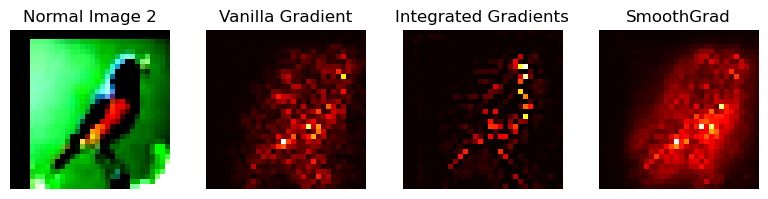

In [33]:
index = indexes[6]
nr_images = 2
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(nr_images*4, int(nr_images)))

#plot normal
axes[0].imshow(np.moveaxis(x_batch[index], 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text(f"Normal Image {y_batch[index].item()}")
axes[0].axis("off")
axes[1].imshow(a_batch_saliency[index], cmap="hot")
axes[1].title.set_text(f"Vanilla Gradient")
axes[1].axis("off")  
axes[2].imshow(a_batch_integrad[index], cmap="hot")
axes[2].title.set_text(f"Integrated Gradients")
axes[2].axis("off")
axes[3].imshow(a_batch_smoothgrad[index], cmap="hot")
axes[3].title.set_text(f"SmoothGrad")
axes[3].axis("off")
plt.tight_layout()

plt.savefig('Explanations/vgg_normal.png')
plt.show()

# Adversarial Training VGG

In [35]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "vgg_cifar_adv.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
model_adv = vgg16().to(device)
model_adv.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [36]:
# Model to GPU and eval mode.
model_adv.to(device)
model_adv.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_adv, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG Adversarial is: {(100 * test_acc):.2f}%")

Test accuracy for VGG Adversarial is: 86.47%


In [37]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [38]:
a_batch_integrad_adv = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model_adv).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy())
a_batch_integrad_adv[a_batch_integrad_adv<0] = 0
a_batch_saliency_adv = quantus.normalise_func.normalise_by_negative(Saliency(model_adv).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy())
saliency = Saliency(model_adv)
a_batch_smoothgrad_adv = quantus.normalise_func.normalise_by_negative(NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy())
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


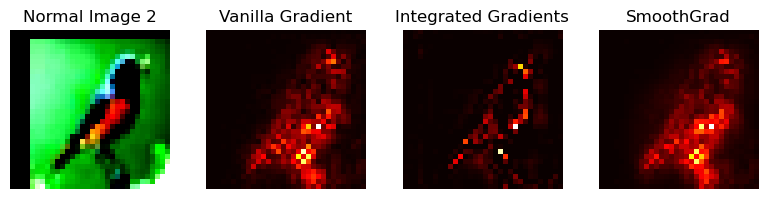

In [39]:

# axes[0].imshow(np.moveaxis(x_batch[index].cpu().numpy(), 0, -1), vmin=0.0, vmax=1.0)
nr_images = 2
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(nr_images*4., int(nr_images)))

#plot normal
axes[0].imshow(np.moveaxis(x_batch[index], 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text(f"Normal Image {y_batch[index].item()}")
axes[0].axis("off")
axes[1].imshow(a_batch_saliency_adv[index], cmap="hot")
axes[1].title.set_text(f"Vanilla Gradient")
axes[1].axis("off")  
axes[2].imshow(a_batch_integrad_adv[index], cmap="hot")
axes[2].title.set_text(f"Integrated Gradients")
axes[2].axis("off")
axes[3].imshow(a_batch_smoothgrad_adv[index], cmap="hot")
axes[3].title.set_text(f"SmoothGrad")
axes[3].axis("off")

plt.tight_layout()
plt.savefig('Explanations/vgg_adversarial.png')

plt.show()

# Pruning L1 Unstructured VGG

In [41]:
def compute_sparsity(model):
    conv1_sparsity = (torch.sum(model.features[0].weight == 0) / model.features[0].weight.nelement()) * 100
    conv2_sparsity = (torch.sum(model.features[2].weight == 0) / model.features[2].weight.nelement()) * 100
    conv3_sparsity = (torch.sum(model.features[5].weight == 0) / model.features[5].weight.nelement()) * 100
    conv4_sparsity = (torch.sum(model.features[7].weight == 0) / model.features[7].weight.nelement()) * 100
    conv5_sparsity = (torch.sum(model.features[10].weight == 0) / model.features[10].weight.nelement()) * 100
    conv6_sparsity = (torch.sum(model.features[12].weight == 0) / model.features[12].weight.nelement()) * 100
    conv7_sparsity = (torch.sum(model.features[14].weight == 0) / model.features[14].weight.nelement()) * 100
    conv8_sparsity = (torch.sum(model.features[17].weight == 0) / model.features[17].weight.nelement()) * 100
    conv9_sparsity = (torch.sum(model.features[19].weight == 0) / model.features[19].weight.nelement()) * 100
    conv10_sparsity = (torch.sum(model.features[21].weight == 0) / model.features[21].weight.nelement()) * 100
    conv11_sparsity = (torch.sum(model.features[24].weight == 0) / model.features[24].weight.nelement()) * 100
    conv12_sparsity = (torch.sum(model.features[26].weight == 0) / model.features[26].weight.nelement()) * 100
    conv13_sparsity = (torch.sum(model.features[28].weight == 0) / model.features[28].weight.nelement()) * 100
    fc1_sparsity = (torch.sum(model.classifier[1].weight == 0) / model.classifier[1].weight.nelement()) * 100
    fc2_sparsity = (torch.sum(model.classifier[4].weight == 0) / model.classifier[4].weight.nelement()) * 100
    op_sparsity = (torch.sum(model.classifier[6].weight == 0) / model.classifier[6].weight.nelement()) * 100

    num = torch.sum(model.features[0].weight == 0) + torch.sum(model.features[2].weight == 0) + torch.sum(model.features[5].weight == 0) + torch.sum(model.features[7].weight == 0) + torch.sum(model.features[10].weight == 0) + torch.sum(model.features[12].weight == 0) + torch.sum(model.features[14].weight == 0) + torch.sum(model.features[17].weight == 0) + torch.sum(model.features[19].weight == 0) + torch.sum(model.features[21].weight == 0)+ torch.sum(model.features[24].weight == 0) + torch.sum(model.features[26].weight == 0) + torch.sum(model.features[28].weight == 0) + torch.sum(model.classifier[1].weight == 0) + torch.sum(model.classifier[4].weight == 0) + torch.sum(model.classifier[6].weight == 0)
    denom = model.features[0].weight.nelement() + model.features[2].weight.nelement() + model.features[5].weight.nelement() + model.features[7].weight.nelement() + model.features[10].weight.nelement() + model.features[12].weight.nelement() + model.features[14].weight.nelement() + model.features[17].weight.nelement() + model.features[19].weight.nelement() + model.features[21].weight.nelement() + model.features[24].weight.nelement() + model.features[26].weight.nelement() + model.features[28].weight.nelement() + model.classifier[1].weight.nelement() + model.classifier[4].weight.nelement() + model.classifier[6].weight.nelement()
    global_sparsity = num/denom * 100
    return global_sparsity

In [42]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "vgg_cifar_l1_unstructured.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
model_l1_unstructured = vgg16().to(device)

for name, module in model_l1_unstructured.named_modules():
    # prune 20% of weights/connections in for all hidden layaers-
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.2)
    
    # prune 10% of weights/connections for output layer-
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.1)

print(f"VGG global sparsity = {compute_sparsity(model_l1_unstructured):.2f}%")
model_l1_unstructured.load_state_dict(torch.load(MODEL_SAVE_PATH))

VGG global sparsity = 19.65%


<All keys matched successfully>

In [43]:
# Model to GPU and eval mode.
model_l1_unstructured.to(device)
model_l1_unstructured.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_l1_unstructured, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG Pruned L1 UnStructure is: {(100 * test_acc):.2f}%")

Test accuracy for VGG Pruned L1 UnStructure is: 86.08%


In [44]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [45]:
a_batch_integrad_l1 = IntegratedGradients(model_l1_unstructured).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad_l1[a_batch_integrad_l1<0] = 0
a_batch_saliency_l1 = Saliency(model_l1_unstructured).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model_l1_unstructured)
a_batch_smoothgrad_l1 = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


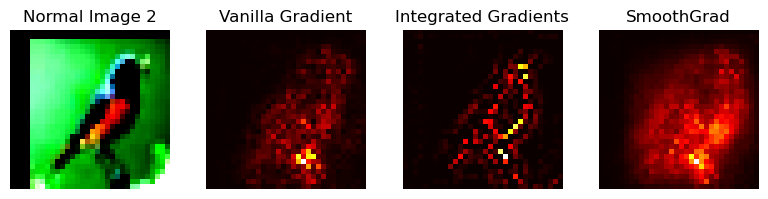

In [46]:

nr_images = 2
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(nr_images*4., int(nr_images)))

#plot normal
axes[0].imshow(np.moveaxis(x_batch[index], 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text(f"Normal Image {y_batch[index].item()}")
axes[0].axis("off")
axes[1].imshow(a_batch_saliency_l1[index], cmap="hot")
axes[1].title.set_text(f"Vanilla Gradient")
axes[1].axis("off")  
axes[2].imshow(a_batch_integrad_l1[index], cmap="hot")
axes[2].title.set_text(f"Integrated Gradients")
axes[2].axis("off")
axes[3].imshow(a_batch_smoothgrad_l1[index], cmap="hot")
axes[3].title.set_text(f"SmoothGrad")
axes[3].axis("off")

plt.tight_layout()
plt.savefig('Explanations/vgg_l1_unstructured.png')

plt.show()

# Global Pruned VGG

In [48]:
from pathlib import Path

prune_rates_global = [0.2, 0.3, 0.4, 0.5, 0.6]

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "vgg_cifar_global.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
model_global = vgg16().to(device)

parameters_to_prune = (
    (model_global.features[0], 'weight'),
    (model_global.features[2], 'weight'),
    (model_global.features[5], 'weight'),
    (model_global.features[7], 'weight'),
    (model_global.features[10], 'weight'),
    (model_global.features[12], 'weight'),
    (model_global.features[14], 'weight'),
    (model_global.features[17], 'weight'),
    (model_global.features[19], 'weight'),
    (model_global.features[21], 'weight'),
    (model_global.features[24], 'weight'),
    (model_global.features[26], 'weight'),
    (model_global.features[28], 'weight'),
    (model_global.classifier[1], 'weight'),
    (model_global.classifier[4], 'weight'),
    (model_global.classifier[6], 'weight')
)

for iter_prune_round in range(1):
    print(f"\n\nIterative Global pruning round = {iter_prune_round + 1}")
    
    # Prune layer-wise in a structured manner-
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method = prune.L1Unstructured,
        amount = prune_rates_global[iter_prune_round]
        
    )

    # Print current global sparsity level-
    print(f"VGG global sparsity = {compute_sparsity(model_global):.2f}%")

        
model_global.load_state_dict(torch.load(MODEL_SAVE_PATH))



Iterative Global pruning round = 1
VGG global sparsity = 20.00%


<All keys matched successfully>

In [49]:
# Model to GPU and eval mode.
model_global.to(device)
model_global.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_global, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG Pruned Global is: {(100 * test_acc):.2f}%")

Test accuracy for VGG Pruned Global is: 83.73%


In [50]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [51]:
a_batch_integrad_global = IntegratedGradients(model_global).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad_global[a_batch_integrad_global<0] = 0
a_batch_saliency_global =Saliency(model_global).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model_global)
a_batch_smoothgrad_global = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()

x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


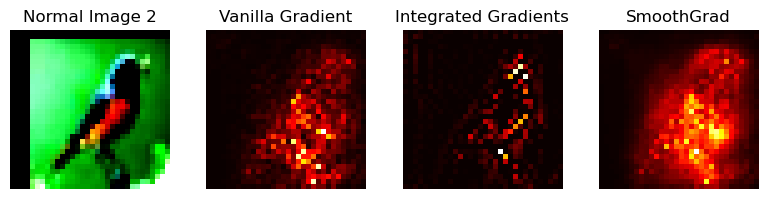

In [52]:
nr_images = 2
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(nr_images*4., int(nr_images)))

#plot normal
axes[0].imshow(np.moveaxis(x_batch[index], 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text(f"Normal Image {y_batch[index].item()}")
axes[0].axis("off")
axes[1].imshow(a_batch_saliency_global[index], cmap="hot")
axes[1].title.set_text(f"Vanilla Gradient")
axes[1].axis("off")  
axes[2].imshow(a_batch_integrad_global[index], cmap="hot")
axes[2].title.set_text(f"Integrated Gradients")
axes[2].axis("off")
axes[3].imshow(a_batch_smoothgrad_global[index], cmap="hot")
axes[3].title.set_text(f"SmoothGrad")
axes[3].axis("off")

plt.tight_layout()
plt.savefig('Explanations/vgg_global.png')

plt.show()

In [53]:
# Pruning Layered Structured VGG

In [54]:
def count_params(model):
    total_parameters = 0
    for layer, param in model.named_parameters():
        total_parameters += torch.count_nonzero(param.data)
    return total_parameters

In [55]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "vgg_cifar_structured.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
model_structured = vgg16().to(device)

# # Prune layer-wise in a structured manner-
prune.ln_structured(model_structured.features[0], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[2], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[5], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[7], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[10], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[12], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[14], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[17], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[19], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[21], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[24], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[26], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[28], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.classifier[1], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.classifier[4], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.classifier[6], name = "weight", amount = 0.1, n = 2, dim = 0)

# Print current global sparsity level-
print(f"VGG global sparsity = {compute_sparsity(model_structured):.2f}%")

model_structured.load_state_dict(torch.load(MODEL_SAVE_PATH))


VGG global sparsity = 9.98%


<All keys matched successfully>

In [56]:
new_params = count_params(model_structured)
print(f"Pruned VGG model has {new_params} trainable parameters")

Pruned VGG model has 15244708 trainable parameters


In [57]:
# Model to GPU and eval mode.
model_structured.to(device)
model_structured.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_structured, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG Pruned Layered Structure is: {(100 * test_acc):.2f}%")

Test accuracy for VGG Pruned Layered Structure is: 85.68%


In [58]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [59]:
a_batch_integrad_structured = IntegratedGradients(model_structured).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad_structured[a_batch_integrad_structured<0] = 0
a_batch_saliency_structured = Saliency(model_structured).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model_structured)
a_batch_smoothgrad_structured = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()

x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


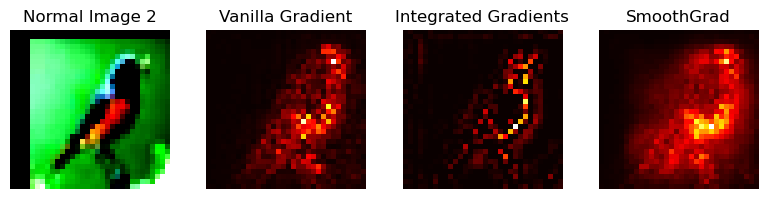

In [60]:

nr_images = 2
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(nr_images*4., int(nr_images)))

#plot normal
axes[0].imshow(np.moveaxis(x_batch[index], 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text(f"Normal Image {y_batch[index].item()}")
axes[0].axis("off")
axes[1].imshow(a_batch_saliency_structured[index], cmap="hot")
axes[1].title.set_text(f"Vanilla Gradient")
axes[1].axis("off")  
axes[2].imshow(a_batch_integrad_structured[index], cmap="hot")
axes[2].title.set_text(f"Integrated Gradients")
axes[2].axis("off")
axes[3].imshow(a_batch_smoothgrad_structured[index], cmap="hot")
axes[3].title.set_text(f"SmoothGrad")
axes[3].axis("off")

plt.tight_layout()
plt.savefig('Explanations/vgg_layered_structure.png')

plt.show()

# Quantitative Metrics Explanation

In [91]:
def explainer_wrapper(**kwargs):
    if kwargs["method"] == "SmoothGrad":
        return smoothgrad_explainer(**kwargs)
    else:
        return ValueError("Explanation function doesnt exist")



def smoothgrad_explainer(model, inputs, targets, abs=True, normalise=True, stdevs=0.15, nt_samples=10, *args, **kwargs):
    std = kwargs.get("std", 0.15)  # Standard deviation for input noise
    n = kwargs.get("n", 10)  # Number of noisy samples
    clip = kwargs.get("clip", False)

    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs).reshape(-1,kwargs.get("nr_channels", 3),kwargs.get("img_size", 32),kwargs.get("img_size", 32),).to(kwargs.get("device", None))
        )
    
    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(kwargs.get("device", None))

    assert (len(np.shape(inputs)) == 4), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size"

    if inputs.shape[0] > 1:
        explanation = torch.zeros(
            (
                n,
                inputs.shape[0],
                kwargs.get("img_size", 32),
                kwargs.get("img_size", 32),
            )
        )
    else:
        explanation = torch.zeros(
            (n, kwargs.get("img_size", 32), kwargs.get("img_size", 32))
        )
    saliency = Saliency(model)
    
    explanation = (
        NoiseTunnel(saliency)
        .attribute(inputs=inputs, target=targets, nt_type="smoothgrad", stdevs = stdevs, nt_samples= 10)
        .sum(axis=1)
        .reshape(-1, kwargs.get("img_size", 32), kwargs.get("img_size", 32))
        .cpu()
        .data
    )

    # explanation = explanation.mean(axis=0)
    gc.collect()
    torch.cuda.empty_cache()

    explanation = explanation.numpy()
    # Normalization (if required)
    if normalise:
        explanation = quantus.normalise_func.normalise_by_negative(explanation)

    # Convert the result to NumPy if it is still a PyTorch tensor
    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation

# # # SmoothGrad
# gc.collect()
# torch.cuda.empty_cache()
# a_batch_smoothgrad_custom = smoothgrad_explainer(model=model.to(device), 
#                                         inputs=x_batch, 
#                                         targets=y_batch,
#                                         **{ "device": device})

# gc.collect()
# torch.cuda.empty_cache()
# a_batch_smoothgrad_adv_custom = smoothgrad_explainer(model=model_adv.to(device), 
#                                         inputs=x_batch, 
#                                         targets=y_batch,
#                                         **{ "device": device})


In [93]:
xai_method=["SmoothGrad"]

In [95]:
gc.collect()
torch.cuda.empty_cache()

In [97]:
def filter_and_compute_road_saliency_ig(model, test_loader,method, device):

    faithfulness = quantus.ROAD(
    noise=0.01,
    perturb_func=quantus.perturb_func.noisy_linear_imputation,
    percentages=list(range(1, 100, 5)),
    display_progressbar=False)


    score_faithfulness = []

    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #print(len(x_batch))
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        #print(correct_mask)
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        #print(len(x_batch))
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = faithfulness(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= quantus.explain,
                explain_func_kwargs = {"method": method, "softmax": False})
        #print(scores)
        
        score_faithfulness.append(scores)
        if len(score_faithfulness) > 1000:
            break
    average_values = {}
    for d in score_faithfulness:
        for key, value in d.items():
            if key in average_values:
                average_values[key] += value
            else:
                average_values[key] = value

    # Divide the sum by the number of dictionaries to get the average
    num_dicts = len(score_faithfulness)
    for key in average_values.keys():
        average_values[key] /= num_dicts

    return average_values


In [99]:
result_normal = filter_and_compute_road_saliency_ig(model, test_dataloader, "Saliency", device)

In [100]:
result_adv = filter_and_compute_road_saliency_ig(model_adv, test_dataloader,"Saliency", device)

In [101]:
result_l1 = filter_and_compute_road_saliency_ig(model_l1_unstructured, test_dataloader,"Saliency", device)

In [102]:
result_global = filter_and_compute_road_saliency_ig(model_global, test_dataloader,"Saliency", device)

In [103]:
result_structured = filter_and_compute_road_saliency_ig(model_structured, test_dataloader,"Saliency", device)

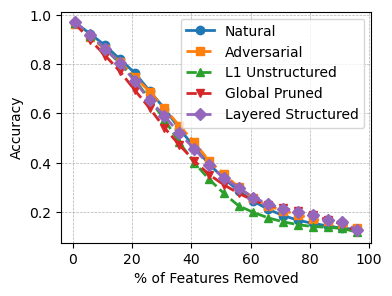

In [113]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(list(result_normal.keys()),list(result_normal.values()), label='Natural', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_adv.values()), label='Adversarial', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_l1.values()), label='L1 Unstructured', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_global.values()), label='Global Pruned', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_structured.values()), label='Layered Structured', linestyle='--', marker='D', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=10)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("roadplots/VGG_CIFAR_SALIENCY_ROAD.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

In [115]:
gc.collect()
torch.cuda.empty_cache()

In [117]:
result_normal_ig = filter_and_compute_road_saliency_ig(model, test_dataloader,"IntegratedGradients", device)

In [118]:
result_adv_ig = filter_and_compute_road_saliency_ig(model_adv, test_dataloader,"IntegratedGradients", device)

In [119]:
result_l1_ig = filter_and_compute_road_saliency_ig(model_l1_unstructured, test_dataloader,"IntegratedGradients", device)

In [120]:
result_global_ig = filter_and_compute_road_saliency_ig(model_global, test_dataloader,"IntegratedGradients", device)

In [121]:
result_structured_ig = filter_and_compute_road_saliency_ig(model_structured, test_dataloader,"IntegratedGradients", device)

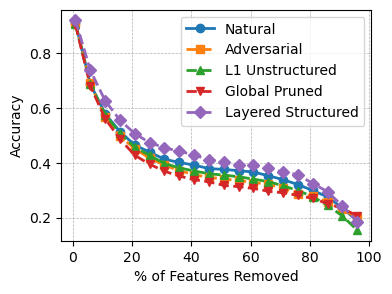

In [122]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(list(result_normal_ig.keys()),list(result_normal_ig.values()), label='Natural', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal_ig.keys()), list(result_adv_ig.values()), label='Adversarial', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal_ig.keys()), list(result_l1_ig.values()), label='L1 Unstructured', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal_ig.keys()), list(result_global_ig.values()), label='Global Pruned', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal_ig.keys()), list(result_structured_ig.values()), label='Layered Structured', linestyle='--', marker='D', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=10)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("roadplots/VGG_CIFAR_IG_ROAD.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

In [129]:
def filter_and_compute_road_smooth(model, test_loader, device):

    faithfulness = quantus.ROAD(
    noise=0.01,
    perturb_func=quantus.perturb_func.noisy_linear_imputation,
    percentages=list(range(1, 100, 5)),
    display_progressbar=False)


    score_faithfulness = []

    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #print(len(x_batch))
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        #print(correct_mask)
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        #print(len(x_batch))
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = faithfulness(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= explainer_wrapper,
                explain_func_kwargs = {
                    "method": xai_method[0],
                    "posterior_mean": copy.deepcopy(
                        model
                        .to(device)
                        .state_dict()
                    ),
                    "mean": 1.0,
                    "std": 0.5,
                    "n": 25,
                    "device": device,
                },
        )
        #print(scores)
        
        score_faithfulness.append(scores)
        if len(score_faithfulness) > 1000:
            break
    average_values = {}
    for d in score_faithfulness:
        for key, value in d.items():
            if key in average_values:
                average_values[key] += value
            else:
                average_values[key] = value

    # Divide the sum by the number of dictionaries to get the average
    num_dicts = len(score_faithfulness)
    for key in average_values.keys():
        average_values[key] /= num_dicts

    return average_values

In [131]:
gc.collect()
torch.cuda.empty_cache()

In [133]:
result_normal_smooth = filter_and_compute_road_smooth(model, test_dataloader, device)

In [134]:
result_adv_smooth = filter_and_compute_road_smooth(model_adv, test_dataloader, device)

In [135]:
result_l1_smooth = filter_and_compute_road_smooth(model_l1_unstructured, test_dataloader, device)

In [136]:
result_global_smooth = filter_and_compute_road_smooth(model_global, test_dataloader, device)

In [137]:
result_structured_smooth = filter_and_compute_road_smooth(model_structured, test_dataloader, device)

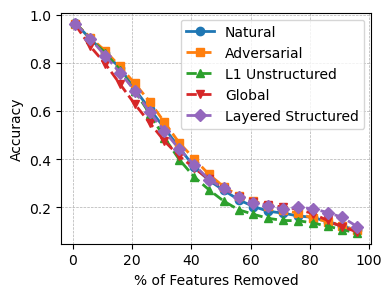

In [138]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(list(result_normal_smooth.keys()),list(result_normal_smooth.values()), label='Natural', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal_smooth.keys()), list(result_adv_smooth.values()), label='Adversarial', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal_smooth.keys()), list(result_l1_smooth.values()), label='L1 Unstructured', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal_smooth.keys()), list(result_global_smooth.values()), label='Global', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal_smooth.keys()), list(result_structured_smooth.values()), label='Layered Structured', linestyle='--', marker='D', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=10)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("roadplots/VGG_CIFAR_SMOOTH_ROAD.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

In [145]:
import math
def filter_and_compute_input_stability_saliency_ig(model, test_loader, method, device):
    
    metrics = quantus.RelativeInputStability(
        nr_samples =5,
        return_aggregate=False,
         disable_warnings=True,
    )
    score = []
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = metrics(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= quantus.explain, 
                explain_func_kwargs = {"method": method, "softmax": False})
        scores2 = np.nanmean(scores)
        score.append(scores2)
        if len(score) > 1000:
            break 
    score2=score
    return math.log(np.nanmean(score2), 10)

In [147]:
gc.collect()
torch.cuda.empty_cache()

In [149]:
normal_input_saliency = filter_and_compute_input_stability_saliency_ig(model, test_dataloader,"Saliency", device)
print("The relative input stability score is: ", normal_input_saliency)

The relative input stability score is:  0.006020467109046703


In [150]:
adversarial_input_saliency = filter_and_compute_input_stability_saliency_ig(model_adv, test_dataloader,"Saliency", device)
print("The relative input stability score is: ", adversarial_input_saliency)

The relative input stability score is:  -0.19088814335252208


In [151]:
l1_input_saliency =  filter_and_compute_input_stability_saliency_ig(model_l1_unstructured, test_dataloader,"Saliency", device)
print("The relative input stability score is: ", l1_input_saliency)

The relative input stability score is:  0.017227563205190668


In [152]:
global_input_saliency = filter_and_compute_input_stability_saliency_ig(model_global, test_dataloader,"Saliency", device)
print("The relative input stability score is: ", global_input_saliency)

The relative input stability score is:  -0.056781665336414204


In [153]:
layered_input_saliency = filter_and_compute_input_stability_saliency_ig(model_structured, test_dataloader,"Saliency", device)
print("The relative input stability score is: ", layered_input_saliency)

The relative input stability score is:  -0.09984659905272394


In [154]:
gc.collect()
torch.cuda.empty_cache()

In [155]:
normal_input_ig  = filter_and_compute_input_stability_saliency_ig(model, test_dataloader,"IntegratedGradients", device)
print("The relative input stability score is: ", normal_input_ig)

The relative input stability score is:  2.08685847840643


In [156]:
adversarial_input_ig = filter_and_compute_input_stability_saliency_ig(model_adv, test_dataloader,"IntegratedGradients", device)
print("The relative input stability score is: ", adversarial_input_ig)

The relative input stability score is:  1.8853065110077558


In [157]:
l1_input_ig = filter_and_compute_input_stability_saliency_ig(model_l1_unstructured, test_dataloader,"IntegratedGradients", device)
print("The relative input stability score is: ",l1_input_ig)

The relative input stability score is:  2.0145407055629363


In [158]:
global_input_ig = filter_and_compute_input_stability_saliency_ig(model_global, test_dataloader,"IntegratedGradients", device)
print("The relative input stability score is: ", global_input_ig)

The relative input stability score is:  1.961932222014994


In [159]:
layered_input_ig = filter_and_compute_input_stability_saliency_ig(model_structured, test_dataloader,"IntegratedGradients", device)
print("The relative input stability score is: ", layered_input_ig)

The relative input stability score is:  1.9071354460887682


In [160]:
import math
def filter_and_compute_input_stability_smooth(model, test_loader, device):
    
    metrics = quantus.RelativeInputStability(
        nr_samples =5,
        return_aggregate=False,
         disable_warnings=True,
    )
    score = []
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = metrics(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= explainer_wrapper,
                explain_func_kwargs = {
                    "method": xai_method[0],
                    "posterior_mean": copy.deepcopy(
                        model
                        .to(device)
                        .state_dict()
                    ),
                    "mean": 1.0,
                    "std": 0.5,
                    "n": 25,
                    "device": device,
                })
        scores2 = np.nanmean(scores)
        score.append(scores2)
        if len(score) > 1000:
            break 
    score2=score
    return math.log(np.nanmean(score2), 10)

In [161]:
gc.collect()
torch.cuda.empty_cache()

In [162]:
normal_input_smooth  =  filter_and_compute_input_stability_smooth(model, test_dataloader, device)
print("The relative input stability score is: ",normal_input_smooth)

The relative input stability score is:  -0.7508587902741357


In [163]:
adversarial_input_smooth =  filter_and_compute_input_stability_smooth(model_adv, test_dataloader, device)
print("The relative input stability score is: ",adversarial_input_smooth)

The relative input stability score is:  -0.7955984504536504


In [164]:
l1_input_smooth = filter_and_compute_input_stability_smooth(model_l1_unstructured, test_dataloader, device)
print("The relative input stability score is: ", l1_input_smooth)

The relative input stability score is:  -0.7299970622654672


In [165]:
global_input_smooth = filter_and_compute_input_stability_smooth(model_global, test_dataloader, device)
print("The relative input stability score is: ", global_input_smooth)

The relative input stability score is:  -0.7369637482492642


In [166]:
layered_input_smooth = filter_and_compute_input_stability_smooth(model_structured, test_dataloader, device)
print("The relative input stability score is: ", layered_input_smooth)

The relative input stability score is:  -0.7939018952691962


In [167]:
vanilla_gradient = [normal_input_saliency, adversarial_input_saliency, l1_input_saliency, global_input_saliency, layered_input_saliency]
integrated_gradients = [normal_input_ig, adversarial_input_ig, l1_input_ig, global_input_ig, layered_input_ig]
smoothgrad = [normal_input_smooth, adversarial_input_smooth, l1_input_smooth, global_input_smooth, layered_input_smooth]

row_labels = ["Normal Model", "Adversarial Model", "L1 Unstructured Pruned", "Global Pruned", "Layered Structured Pruned"]

data = {
    "Vanilla Gradient": vanilla_gradient,
    "Integrated Gradients": integrated_gradients,
    "SmoothGrad": smoothgrad
}

df = pd.DataFrame(data, index = row_labels)

df.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
)

,Vanilla Gradient,Integrated Gradients,SmoothGrad
Normal Model,0.006020,2.086858,-0.750859
Adversarial Model,-0.190888,1.885307,-0.795598
L1 Unstructured Pruned,0.017228,2.014541,-0.729997
Global Pruned,-0.056782,1.961932,-0.736964
Layered Structured Pruned,-0.099847,1.907135,-0.793902


In [184]:
def filter_and_compute_output_stability_saliency_ig(model, test_loader,method, device):
    metrics = quantus.RelativeOutputStability(
        nr_samples = 5,
         return_aggregate=False,
        disable_warnings=True,
    )
    score = []
    
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = metrics(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= quantus.explain, 
                explain_func_kwargs = {"method": method, "softmax": False})
        scores2 = np.nanmean(scores)
        score.append(scores2)
        if len(score) > 1000:
            break 
    score2=score
    return math.log(np.nanmean(score2), 10)

In [185]:
gc.collect()
torch.cuda.empty_cache()

In [186]:
normal_output_saliency = filter_and_compute_output_stability_saliency_ig(model, test_dataloader,"Saliency", device)
print("The relative output stability score is: ", normal_output_saliency)

The relative output stability score is:  2.62351541595986


In [187]:
adversarial_output_saliency = filter_and_compute_output_stability_saliency_ig(model_adv, test_dataloader,"Saliency", device)
print("The relative output stability score is: ", adversarial_output_saliency)

The relative output stability score is:  2.8192255128034915


In [188]:
l1_output_saliency = filter_and_compute_output_stability_saliency_ig(model_l1_unstructured, test_dataloader,"Saliency", device)
print("The relative output stability score is: ", l1_output_saliency)

The relative output stability score is:  2.662823571449896


In [189]:
global_output_saliency = filter_and_compute_output_stability_saliency_ig(model_global, test_dataloader,"Saliency", device)
print("The relative output stability score is: ", global_output_saliency)

The relative output stability score is:  2.600214317912361


In [190]:
layered_output_saliency = filter_and_compute_output_stability_saliency_ig(model_structured, test_dataloader,"Saliency", device)
print("The relative output stability score is: ",layered_output_saliency )

The relative output stability score is:  2.5083992023445467


In [191]:
gc.collect()
torch.cuda.empty_cache()

In [192]:
normal_output_ig = filter_and_compute_output_stability_saliency_ig(model, test_dataloader,"IntegratedGradients", device)
print("The relative output stability score is: ", normal_output_ig)

The relative output stability score is:  4.682335632052278


In [193]:
adversarial_output_ig = filter_and_compute_output_stability_saliency_ig(model_adv, test_dataloader,"IntegratedGradients", device)
print("The relative output stability score is: ", adversarial_output_ig)

The relative output stability score is:  4.673010975859937


In [194]:
l1_output_ig =  filter_and_compute_output_stability_saliency_ig(model_l1_unstructured, test_dataloader,"IntegratedGradients", device)
print("The relative output stability score is: ",l1_output_ig)

The relative output stability score is:  4.56845332206729


In [195]:
global_output_ig = filter_and_compute_output_stability_saliency_ig(model_global, test_dataloader,"IntegratedGradients", device)
print("The relative output stability score is: ",global_output_ig )

The relative output stability score is:  4.619938831280848


In [196]:
layered_output_ig = filter_and_compute_output_stability_saliency_ig(model_structured, test_dataloader,"IntegratedGradients", device)
print("The relative output stability score is: ", layered_output_ig)

The relative output stability score is:  4.4482123373710305


In [197]:
def filter_and_compute_output_stability_smooth(model, test_loader, device):
    metrics = quantus.RelativeOutputStability(
        nr_samples = 5,
         return_aggregate=False,
        disable_warnings=True,
    )
    score = []
    
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = metrics(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= explainer_wrapper,
                explain_func_kwargs = {
                    "method": xai_method[0],
                    "posterior_mean": copy.deepcopy(
                        model
                        .to(device)
                        .state_dict()
                    ),
                    "mean": 1.0,
                    "std": 0.5,
                    "n": 25,
                    "device": device,
                })
        scores2 = np.nanmean(scores)
        score.append(scores2)
        if len(score) > 1000:
            break 
    score2=score
    return math.log(np.nanmean(score2), 10)

In [198]:
gc.collect()
torch.cuda.empty_cache()

In [199]:
normal_output_smooth =  filter_and_compute_output_stability_smooth(model, test_dataloader, device)
print("The relative output stability score is: ",normal_output_smooth)

The relative output stability score is:  1.9232326393815664


In [200]:
adversarial_output_smooth =  filter_and_compute_output_stability_smooth(model_adv, test_dataloader, device)
print("The relative output stability score is: ",adversarial_output_smooth)

The relative output stability score is:  2.253182188840668


In [201]:
l1_output_smooth = filter_and_compute_output_stability_smooth(model_l1_unstructured, test_dataloader, device)
print("The relative output stability score is: ", l1_output_smooth)

The relative output stability score is:  1.947890604758193


In [202]:
global_output_smooth = filter_and_compute_output_stability_smooth(model_global, test_dataloader, device)
print("The relative output stability score is: ", global_output_smooth)

The relative output stability score is:  1.969694682956773


In [203]:
layered_output_smooth = filter_and_compute_output_stability_smooth(model_structured, test_dataloader, device)
print("The relative output stability score is: ", layered_output_smooth)

The relative output stability score is:  1.843029696947983


In [204]:
vanilla_gradient = [normal_output_saliency, adversarial_output_saliency, l1_output_saliency, global_output_saliency, layered_output_saliency]
integrated_gradients = [normal_output_ig, adversarial_output_ig, l1_output_ig, global_output_ig, layered_output_ig]
smoothgrad = [normal_output_smooth, adversarial_output_smooth, l1_output_smooth, global_output_smooth, layered_output_smooth]

row_labels = ["Normal Model", "Adversarial Model", "L1 Unstructured Pruned", "Global Pruned", "Layered Structured Pruned"]

data = {
    "Vanilla Gradient": vanilla_gradient,
    "Integrated Gradients": integrated_gradients,
    "SmoothGrad": smoothgrad
}

df = pd.DataFrame(data, index = row_labels)

df.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
)

,Vanilla Gradient,Integrated Gradients,SmoothGrad
Normal Model,2.623515,4.682336,1.923233
Adversarial Model,2.819226,4.673011,2.253182
L1 Unstructured Pruned,2.662824,4.568453,1.947891
Global Pruned,2.600214,4.619939,1.969695
Layered Structured Pruned,2.508399,4.448212,1.843030


In [205]:
def filter_and_compute_sparsity_saliency_ig(model, test_loader,method, device):
    
    sparsity = quantus.Sparseness(disable_warnings=True, return_aggregate=True)
    score_sparsity = []

    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #print(len(x_batch))
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        #print(correct_mask)
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        #print(len(x_batch))
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = sparsity(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= quantus.explain, 
                explain_func_kwargs = {"method": method, "softmax": False})
        score_sparsity.extend(scores)
        if len(score_sparsity) > 1000:
            break 
    return np.nanmean(score_sparsity), np.nanstd(score_sparsity)

In [206]:
gc.collect()
torch.cuda.empty_cache()

In [207]:
normal_sparse_saliency = filter_and_compute_sparsity_saliency_ig(model, test_dataloader,"Saliency", device)
print("The sparsity score is: ", normal_sparse_saliency)

The sparsity score is:  (0.5726994638395948, 0.004584305892854839)


In [208]:
adversarial_sparse_saliency = filter_and_compute_sparsity_saliency_ig(model_adv, test_dataloader,"Saliency", device)
print("The sparsity score is: ", adversarial_sparse_saliency)

The sparsity score is:  (0.5972986099098042, 0.004904099955738187)


In [209]:
l1_sparse_saliency =  filter_and_compute_sparsity_saliency_ig(model_l1_unstructured, test_dataloader,"Saliency", device)
print("The sparsity score is: ",l1_sparse_saliency)

The sparsity score is:  (0.5738094976392467, 0.005116665733681111)


In [210]:
global_sparse_saliency = filter_and_compute_sparsity_saliency_ig(model_global, test_dataloader,"Saliency", device)
print("The sparsity score is: ", global_sparse_saliency)

The sparsity score is:  (0.5624702731796459, 0.005317814904009483)


In [211]:
layered_sparse_saliency = filter_and_compute_sparsity_saliency_ig(model_structured, test_dataloader,"Saliency", device)
print("The sparsity score is: ",layered_sparse_saliency  )

The sparsity score is:  (0.5122827342001331, 0.017010550552633678)


In [212]:
gc.collect()
torch.cuda.empty_cache()

In [213]:
normal_sparse_ig =  filter_and_compute_sparsity_saliency_ig(model, test_dataloader,"IntegratedGradients", device)
print("The sparsity score is: ",normal_sparse_ig)

The sparsity score is:  (0.6501560334004735, 0.0038958996317912387)


In [214]:
adversarial_sparse_ig = filter_and_compute_sparsity_saliency_ig(model_adv, test_dataloader,"IntegratedGradients", device)
print("The sparsity score is: ",adversarial_sparse_ig )

The sparsity score is:  (0.6719259052821809, 0.004295748463367508)


In [215]:
l1_sparse_ig = filter_and_compute_sparsity_saliency_ig(model_l1_unstructured, test_dataloader,"IntegratedGradients", device)
print("The sparsity score is: ", l1_sparse_ig)

The sparsity score is:  (0.6560931448904695, 0.004290100112678763)


In [216]:
global_sparse_ig = filter_and_compute_sparsity_saliency_ig(model_global, test_dataloader,"IntegratedGradients", device)
print("The sparsity score is: ",global_sparse_ig )

The sparsity score is:  (0.6351893832086976, 0.004785989095752681)


In [217]:
layered_sparse_ig = filter_and_compute_sparsity_saliency_ig(model_structured, test_dataloader,"IntegratedGradients", device)
print("The sparsity score is: ", layered_sparse_ig)

The sparsity score is:  (0.5758098355768306, 0.019984059895344727)


In [218]:
def filter_and_compute_sparsity_smooth(model, test_loader, device):
    
    sparsity = quantus.Sparseness(disable_warnings=True, return_aggregate=True)
    score_sparsity = []

    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #print(len(x_batch))
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        #print(correct_mask)
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        #print(len(x_batch))
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = sparsity(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                 explain_func= explainer_wrapper,
                explain_func_kwargs = {
                    "method": xai_method[0],
                    "posterior_mean": copy.deepcopy(
                        model
                        .to(device)
                        .state_dict()
                    ),
                    "mean": 1.0,
                    "std": 0.5,
                    "n": 25,
                    "device": device,
                })
        score_sparsity.extend(scores)
        if len(score_sparsity) > 1000:
            break 
    return np.nanmean(score_sparsity), np.nanstd(score_sparsity)

In [219]:
gc.collect()
torch.cuda.empty_cache()

In [220]:
normal_sparse_smooth = filter_and_compute_sparsity_smooth(model, test_dataloader, device)
print("The sparsity score is: ",normal_sparse_smooth )

The sparsity score is:  (0.4657412467932185, 0.005326518347014147)


In [221]:
adversarial_sparse_smooth = filter_and_compute_sparsity_smooth(model_adv, test_dataloader, device)
print("The sparsity score is: ", adversarial_sparse_smooth)

The sparsity score is:  (0.5190453759394414, 0.005456594232724554)


In [222]:
l1_sparse_smooth = filter_and_compute_sparsity_smooth(model_l1_unstructured, test_dataloader, device)
print("The sparsity score is: ", l1_sparse_smooth)

The sparsity score is:  (0.46498667493850254, 0.005974374413143117)


In [223]:
global_sparse_smooth = filter_and_compute_sparsity_smooth(model_global, test_dataloader, device)
print("The sparsity score is: ", global_sparse_smooth)

The sparsity score is:  (0.46332769971628734, 0.006009343492445573)


In [224]:
layered_sparse_smooth =  filter_and_compute_sparsity_smooth(model_structured, test_dataloader, device)
print("The sparsity score is: ",layered_sparse_smooth)

The sparsity score is:  (0.4188853146879053, 0.013438792225912263)


In [225]:
vanilla_gradient = [normal_sparse_saliency, adversarial_sparse_saliency, l1_sparse_saliency, global_sparse_saliency, layered_sparse_saliency]
integrated_gradients = [normal_sparse_ig, adversarial_sparse_ig, l1_sparse_ig, global_sparse_ig, layered_sparse_ig]
smoothgrad = [normal_sparse_smooth, adversarial_sparse_smooth, l1_sparse_smooth, global_sparse_smooth, layered_sparse_smooth]

row_labels = ["Normal Model", "Adversarial Model", "L1 Unstructured Pruned", "Global Pruned", "Layered Structured Pruned"]

data = {
    "Vanilla Gradient": vanilla_gradient,
    "Integrated Gradients": integrated_gradients,
    "SmoothGrad": smoothgrad
}

df = pd.DataFrame(data, index = row_labels)

df.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
)

,Vanilla Gradient,Integrated Gradients,SmoothGrad
Normal Model,"(0.5726994638395948, 0.004584305892854839)","(0.6501560334004735, 0.0038958996317912387)","(0.4657412467932185, 0.005326518347014147)"
Adversarial Model,"(0.5972986099098042, 0.004904099955738187)","(0.6719259052821809, 0.004295748463367508)","(0.5190453759394414, 0.005456594232724554)"
L1 Unstructured Pruned,"(0.5738094976392467, 0.005116665733681111)","(0.6560931448904695, 0.004290100112678763)","(0.46498667493850254, 0.005974374413143117)"
Global Pruned,"(0.5624702731796459, 0.005317814904009483)","(0.6351893832086976, 0.004785989095752681)","(0.46332769971628734, 0.006009343492445573)"
Layered Structured Pruned,"(0.5122827342001331, 0.017010550552633678)","(0.5758098355768306, 0.019984059895344727)","(0.4188853146879053, 0.013438792225912263)"
